In [ ]:
import polars as pl
import pandas as pd

In [ ]:
df = pl.read_csv("./train.csv")

# Data Cleaning

In [ ]:
df2 = df.with_columns(
    pl.col("Name").map_elements(lambda x: x.split(', ')[0]).alias('Last'),
    pl.col("Name").map_elements(lambda x: x.split(', ')[1].split('. ')[1]).alias('First'),
    pl.col("Name").map_elements(lambda x: x.split(', ')[1].split('. ')[0]).alias('Sfx'),
    pl.col("Name").map_elements(lambda x: x.split(', ')[1].split('. ')[1].split('(')[-1].split(')')[0] if '(' in x else None).alias('Second Name')
    )

In [ ]:
df3 = df2.with_columns(
    pl.when(pl.col('Second Name').is_null()).then(0).otherwise(1).alias('Has Second Name'),
    pl.col('Age').map_elements(lambda x: 1 if x >= 18 else 0).alias('Adult')
)

In [ ]:
df3

# Predict Age of Passengers

#### Useful Attributes to Predict Age
- Parch
- Sfx
- Has Second Name
- Fare
- Pclass

#### Ideas
- Round each of the ages to the nearest half decade
- Design custom buckets or bins for age groups
    - Baby: 0-3
    - Youth: 4-12
    - Teen: 13-17
    - Young Adult: 18-25
    - Adult: 26-40
    - Older Adult: 41-55
    - Elder: 56-


In [ ]:
# Filter df to only ages
passengers_with_ages = df3.filter(~pl.col("Age").is_null())

In [26]:
passengers_with_ages_y = passengers_with_ages.select(['Age'])
passengers_with_ages_y = passengers_with_ages_y.with_columns(pl.col("Age").apply(lambda x: round(x/5)*5))
passengers_with_ages_X_cols = ['Parch', 'Sfx', 'Has Second Name', 'Fare', 'Pclass']
passengers_with_ages_X = passengers_with_ages.select(passengers_with_ages_X_cols)

C:\Users\Connor\AppData\Local\Temp\ipykernel_59440\1053288211.py:2: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  passengers_with_ages_y = passengers_with_ages_y.with_columns(pl.col("Age").apply(lambda x: round(x/5)*5))


In [27]:
# Switching to pandas df to create dummy variables the suffixes for each passendger's name
passengers_with_ages_X = passengers_with_ages_X.to_pandas()
passengers_with_ages_y = passengers_with_ages_y.to_pandas()

passengers_with_ages_X = pd.get_dummies(data=passengers_with_ages_X, drop_first=True)

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt

In [29]:
# Randomly sample 95% for training while the reset will be for testing.
ages_X_train, ages_X_test, ages_y_train, ages_y_test = train_test_split(passengers_with_ages_X, passengers_with_ages_y, test_size=0.1, random_state=42)

In [30]:
ages_X_test

,Parch,Has Second Name,Fare,Pclass,Sfx_Col,Sfx_Don,Sfx_Dr,Sfx_Jonkheer,Sfx_Lady,Sfx_Major,Sfx_Master,Sfx_Miss,Sfx_Mlle,Sfx_Mme,Sfx_Mr,Sfx_Mrs,Sfx_Ms,Sfx_Rev,Sfx_Sir,Sfx_the Countess
120,0,0,13.0000,2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
329,1,0,18.7500,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
39,0,1,26.0000,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
294,0,0,69.3000,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
654,0,0,6.4500,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1,0,55.0000,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
591,0,0,7.9250,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
697,0,0,5.0000,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
398,0,0,8.6625,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


## Testing Different Models

In [38]:
reg = linear_model.LinearRegression()
# reg = linear_model.LogisticRegression()

In [39]:
ages_y_train

,Age
593,15
302,20
101,45
525,20
192,20
...,...
71,45
106,25
270,40
435,35


In [40]:
reg.fit(X=ages_X_train, y=ages_y_train)

LinearRegression()

In [41]:
reg.coef_

array([[-7.29668517e-01, -2.72023937e+00, -1.74454107e-02,
        -6.42378090e+00, -1.15051170e+01, -3.14846919e+01,
        -2.91256339e+01, -3.19682927e+01,  5.68434189e-14,
        -2.39706623e+01, -5.61271188e+01, -4.16693836e+01,
        -4.45718790e+01,  0.00000000e+00, -3.02111821e+01,
        -2.58994887e+01, -3.53177214e+01, -1.74962862e+01,
        -1.82549000e+01, -3.27390253e+01]])

In [42]:
ages_y_predict = reg.predict(ages_X_test)

In [43]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(ages_y_test, ages_y_predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(ages_y_test, ages_y_predict))

Mean squared error: 162.59
Coefficient of determination: 0.26


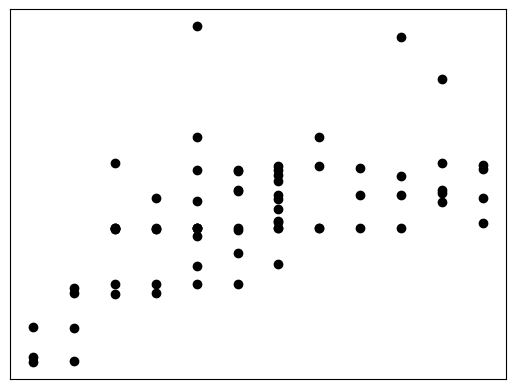

In [44]:
# Plot outputs
plt.scatter(ages_y_test, ages_y_predict, color="black")
# plt.plot(ages_X_test['Fare'], ages_y_predict, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()